In [117]:
import torch
import torch.nn.functional as F
from torch import Tensor
import random
from mynn import *
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
rndSeed = 42
contextSize = 3
trRatio = 0.8
devRatio = 0.9
embeddingSize = 10 # the dimensionality of the character embedding vectors
hiddenLayerSize = 200 # the number of neurons in the hidden layer of the MLP
maxTrainingSteps = 100_000
trainingBatchSize = 64
rndSeed2 = 2147483647
g = torch.Generator().manual_seed(rndSeed2)
gSampling = torch.Generator().manual_seed(rndSeed2 + 10)


words = readFileSplitByLine('names.txt')[:]
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\n', words[:5])

lenWords = len(words);
print('lenWords:\n', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\n', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\n', stoi)

itos = iToS(stoi)
print('itos:\n', itos)

vocabularySize = len(itos)
print('vocabularySize:\n', vocabularySize)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos)
print('data set training:\n', lenTrain, trX.shape, trY.shape)

lenDev = int(devRatio * lenWords)
devWords = words[lenTrain:lenDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos)
print('data set dev:\n', lenDev, devX.shape, devY.shape)

lenTest = lenDev - lenTrain
tstWords = words[lenDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos)
print('data set test:\n', lenTest, tstX.shape, tstY.shape)

np = makeNetwork(g, vocabularySize, embeddingSize, contextSize, hiddenLayerSize)
print('parametersCount:\n', sum(p.nelement() for p in np.all))

lr = 0.1;
lre = torch.linspace(-3, 0, maxTrainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr: ForwardPassResult = ForwardPassResult()

for i in range(maxTrainingSteps):    

    miniBatchIxs = torch.randint(0, trX.shape[0], (trainingBatchSize,), generator=g)
    fr = forwardPass(np, trX, miniBatchIxs, embeddingSize, contextSize, trY)  
    if (i == 0):
        print('initial loss:\n', fr.loss.item());
    backwardPass(np.all, fr.loss)
    
    stepIx.append(i)
    lossAtIx.append(fr.loss.item())
    logLossAtIx.append(fr.loss.log10().item())

    #lr = lrs[i].item()
    #lrAtIx.append(lrs[i].item())
    
    updateNet(np.all, i, lr)
    
    if (((i * trainingBatchSize) > (lenWords * 10)) and (fr.loss.item() < 1.7)):
      print("break", i)
      break

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#print('best learning rate:\n', bestLr)
print('emb.shape:\n', fr.emb.shape)
print('h.shape:\n', fr.h.shape)
print('logits.shape:\n', fr.logits.shape)
print('loss:\n', fr.loss.item())


first few words:
 ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:
 32033
allPossibleChars:
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
vocabularySize:
 27
data set training:
 25626 torch.Size([182625, 3]) torch.Size([182625])
data set dev:
 28829 torch.Size([22655, 3]) torch.Size([22655])
data set test:
 3203 torch.Size([22866, 3]) torch.Size([22866])
parametersCount:
 11897
initial loss:
 26.27082061767578
break

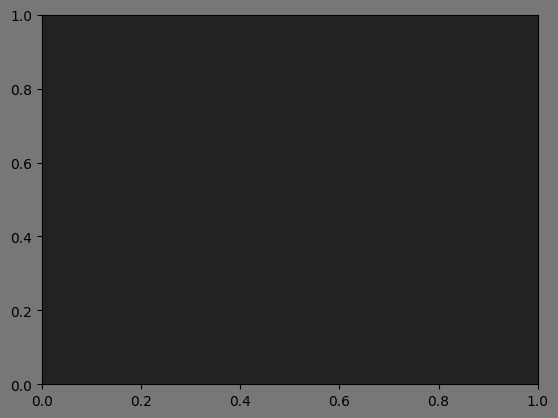

In [119]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
#ax.plot(lrAtIx, lossAtIx)
plt.show()

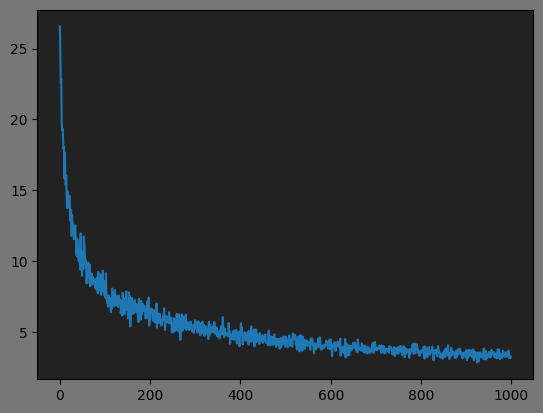

In [120]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, lossAtIx)
plt.show()

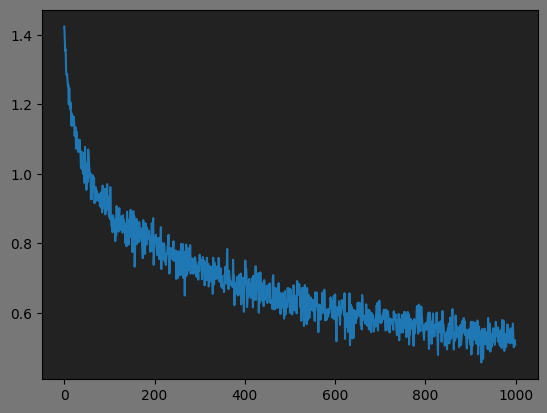

In [121]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, logLossAtIx)
plt.show()

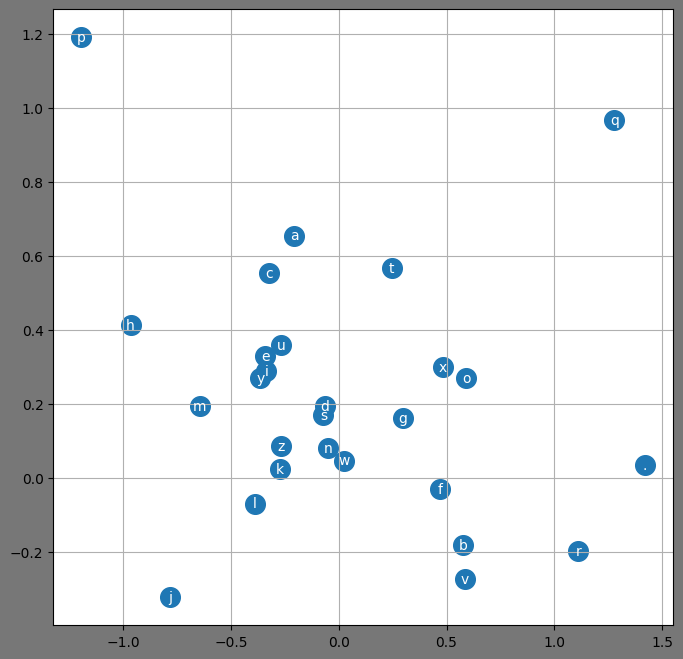

In [122]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [177]:
sample(np, gSampling, contextSize, itos, 20)

mella.
etan.
kylaab.
ava.
jackenna.
kenn.
autt.
ive.
kahe.
arley.
jayeranto.
alde.
cavani.
kailon.
ethaydneekaysen.
yinag.
amars.
zyaryk.
ames.
thne.


In [124]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 1.4210,  0.0339,  0.0106, -0.4868,  0.2204,  0.0400, -1.3540,  0.8727,
           0.3228,  0.8614],
         [-0.2063,  0.6549, -0.3063, -0.7834,  0.7357,  2.5635,  1.7239, -1.1458,
           0.3714, -0.7821],
         [ 0.5771, -0.1814, -1.2019,  0.0060,  0.0525,  2.1340,  1.9970, -0.5102,
          -0.7705,  0.2927],
         [-0.3227,  0.5535,  0.0037,  0.1289, -0.7771, -0.5886, -1.2223,  0.5456,
          -0.9950,  0.7934],
         [-0.0651,  0.1934, -0.1192, -0.1256, -0.1540,  0.5970,  0.3134, -0.1594,
          -0.2525, -0.4527]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 1.4210,  0.0339,  0.0106, -0.4868,  0.2204,  0.0400, -1.3540,
            0.8727,  0.3228,  0.8614],
          [ 1.4210,  0.0339,  0.0106, -0.4868,  0.2204,  0.0400, -1.3540,
            0.8727,  0.3228,  0.86

In [125]:
# Let's suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let's print the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
